In [1]:
# import gymnasium as gym
import gym
from gym import spaces
import numpy as np
import pygame
import pickle
import matplotlib.pyplot as plt

In [135]:
class MazeGameEnv(gym.Env):
    """
        Maze Game Environment

        The maze is represented as a 2D numpy array where:
            'S' is the start position
            'G' is the goal position
            'X' is a wall
            ' ' is an empty space

        The agent can move in 4 directions:
            0: Up
            1: Down
            2: Left
            3: Right

        The agent receives a reward of 1.0 when it reaches the goal position and 0.0 otherwise.

        :param maze: 2D numpy array representing the maze
        :type maze: np.ndarray

        :param cell_size: Size of each cell in the maze
        :type cell_size: int

        :param screen: Pygame screen object
        :type screen: pygame.Surface

        :param start_pos: Start position of the agent
        :type start_pos: Tuple[int, int]

        :param goal_pos: Goal position of the agent
        :type goal_pos: Tuple[int, int]

        :param current_pos: Current position of the agent
        :type current_pos: Tuple[int, int]

        :param num_rows: Number of rows in the maze
        :type num_rows: int

        :param num_cols: Number of columns in the maze
        :type num_cols: int

        :param action_space: Action space of the environment
        :type action_space: gym.spaces.Discrete

        :param observation_space: Observation space of the environment
        :type observation_space: gym.spaces.Tuple

        :param screen: Pygame screen object
        :type screen: pygame.Surface

        :param cell_size: Size of each cell in the maze
        :type cell_size: int
    """

    def __init__(self, maze):
        super().__init__()
        self.maze = np.array(maze) # 2d array
        self.start_pos = (np.where(self.maze == 'S')[0][0], np.where(self.maze == 'S')[1][0])
        self.goal_pos = (np.where(self.maze == 'G')[0][0], np.where(self.maze == 'G')[1][0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape

        self.action_space = spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(self.num_rows * self.num_cols)

        pygame.init()
        self.cell_size = 125
        self.screen = pygame.display.set_mode((self.num_cols * self.cell_size, self.num_rows * self.cell_size))

    def reset(self, seed=None, options=None):
        """
            Reset agent position to start position
        """
        super().reset(seed=seed)
        self.current_pos = self.start_pos
        state_index = self._pos_to_index(self.current_pos)
        return state_index, {}

    def step(self, action):
        """
            Updates agent’s position according to the action taken and provide reward
        """
        new_pos = np.array(self.current_pos)
        if action == 0: # Up
            new_pos[0] -= 1
        if action == 1: # Dwon
            new_pos[0] += 1
        if action == 2: # Left
            new_pos[1] -= 1
        if action == 3:
            new_pos[1] += 1

        if self._is_valid_position(new_pos):
            self.current_pos = new_pos

        if np.array_equal(np.array(self.current_pos), np.array(self.goal_pos)):
            reward = 1.0
            done = True
        else:
            reward = -0.1/(self.num_rows * self.num_cols)
            done = False

        state_index = self._pos_to_index(self.current_pos)
        return state_index, reward, done, False, {}

    def _is_valid_position(self, pos):
        row, col = pos

        if row < 0 or col < 0 or row >= self.num_rows or col >= self.num_cols:
            return False
        
        if self.maze[row, col] == '#':
            return False
        
        return True
    
    def _pos_to_index(self, pos):
        return pos[0] * self.num_cols + pos[1]
    
    def render(self):
        """
            Render game environment using pygame by drawing elements for each cell by using nested loops. 
            You can simply print the maze grid as well, no necessary requirement for pygame
        """
        self.screen.fill((255, 255, 255))

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                # try:
                #     print(np.array(self.current_pos)==np.array([row,col]).reshape(-1,1))
                # except Exception as e:
                #     print('Initial state')

                if self.maze[row, col] == '#':
                    pygame.draw.rect(self.screen, (0, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.rect(self.screen, (0, 255, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'G':
                    pygame.draw.rect(self.screen, (255, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
        
                if np.array_equal(np.array(self.current_pos), np.array([row, col])):  # Agent position
                    pygame.draw.rect(self.screen, (0, 0, 255), (cell_left, cell_top, self.cell_size, self.cell_size))

        pygame.display.update()

In [136]:
gym.register(
    id='MazeGame-v0',
    entry_point=MazeGameEnv,
    kwargs={'maze': None}
)

In [137]:
def run(episodes, is_training=True, render=False):
    """
    Run the maze problem

    :param episodes: number of episodes to run
    :param is_training: if True, the agent will learn, otherwise it will use a pre-trained model
    :return: None
    """

    maze = [
        ['S', '.', '.', '.'],
        ['.', '#', '.', '#'],
        ['.', '#', '.', '.'],
        ['#', '.', '#', 'G'],
    ]

    env = gym.make('MazeGame-v0', maze=maze)

    if(is_training):
        q = np.zeros((16, 4))
    else:
        f = open('maze_game.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9
    discount_factor_g = 0.9

    epsilon = 1
    epsilon_decay_rate = 0.0001
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False
        rewards = 0

        while (not terminated and not truncated):

            if render:
                pygame.event.get()

            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state, :])

            new_state, reward, terminated, truncated, _ = env.step(action)

            if render:
                env.render()
                pygame.time.wait(200)

            if is_training:
                q[state, action] = q[state, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state, :]) - q[state, action]
                )

            state = new_state
            rewards += reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if epsilon == 0:
            learning_rate_a = 0.0001

        rewards_per_episode[i] = rewards

        print(f'Episode {i+1}/{episodes}, rewards: {rewards}')

    env.close()

    if is_training:
        f = open('maze_game.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(mean_rewards)
    plt.savefig(f'maze_game_mean.png')

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.savefig(f'maze_game_sum.png')

Episode 1/15000, rewards: 0.1312500000000021
Episode 2/15000, rewards: -0.4625000000000039
Episode 3/15000, rewards: 0.8875
Episode 4/15000, rewards: -0.12499999999999911
Episode 5/15000, rewards: -0.4562500000000038
Episode 6/15000, rewards: 0.8062499999999999
Episode 7/15000, rewards: -2.1750000000000282
Episode 8/15000, rewards: 0.4687500000000009
Episode 9/15000, rewards: 0.7624999999999998
Episode 10/15000, rewards: 0.6375000000000003
Episode 11/15000, rewards: 0.7437499999999999
Episode 12/15000, rewards: -1.5687500000000196
Episode 13/15000, rewards: 0.6625000000000002
Episode 14/15000, rewards: 0.4937500000000008
Episode 15/15000, rewards: 0.6875000000000001
Episode 16/15000, rewards: 0.7624999999999998
Episode 17/15000, rewards: 0.6875000000000001
Episode 18/15000, rewards: 0.8687499999999999
Episode 19/15000, rewards: -1.3937500000000171
Episode 20/15000, rewards: 0.5375000000000006
Episode 21/15000, rewards: 0.13750000000000207
Episode 22/15000, rewards: -0.33750000000000213

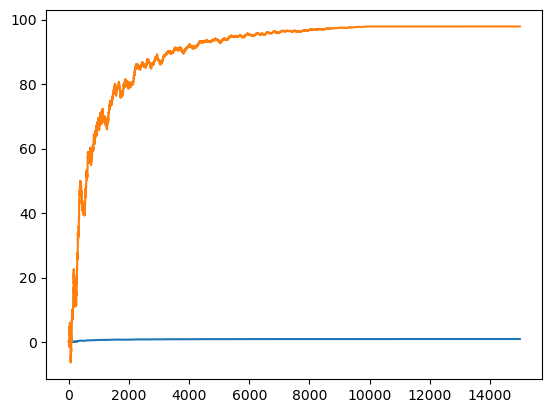

In [138]:
run(15000, is_training=True, render=False)

Episode 1/10, rewards: 0.96875
Episode 2/10, rewards: 0.96875
Episode 3/10, rewards: 0.96875
Episode 4/10, rewards: 0.96875
Episode 5/10, rewards: 0.96875
Episode 6/10, rewards: 0.96875
Episode 7/10, rewards: 0.96875
Episode 8/10, rewards: 0.96875
Episode 9/10, rewards: 0.96875
Episode 10/10, rewards: 0.96875


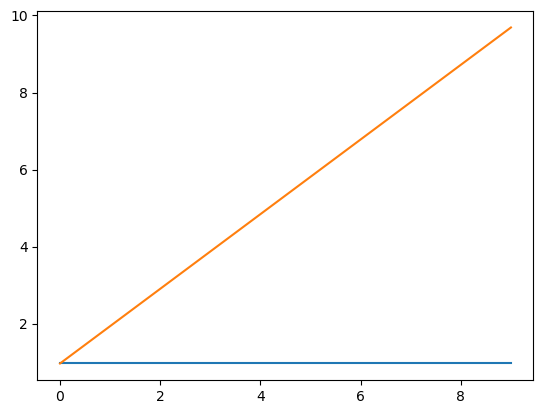

In [139]:
run(10, is_training=False, render=True)